In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from adjustText import adjust_text
from pdb import set_trace as st 
import random
import json
import os 
import cv2
from tqdm import tqdm
import string
from Aux import * 
from Three_V import *


In [2]:
emnist_loc = "/home/yfrid/Desktop/stem-whiteboard/dataset/mnist/EMNIST/raw/"
emnist_images = read_idx_ubyte(emnist_loc+"emnist-byclass-train-images-idx3-ubyte")
emnist_labels = read_idx_ubyte(emnist_loc+"emnist-byclass-train-labels-idx1-ubyte")
emnist_chars = string.digits+string.ascii_uppercase+string.ascii_lowercase

Reading image data: 697932 images of 28x28 pixels.
Reading label data: 697932 labels.


In [15]:
lower_letters = string.ascii_lowercase
greek_letters = ['α', 'β', 'γ', 'δ', 'θ']

def float_to_mnist(num):
    images = []
    for v in num:
        if v == ".":
            mat = np.ones([28,7])
            mat[23:26,2:5] = 0 +np.random.rand(3,3)*0.2
            mat = create_handwritten_dot()
            images.append(1-mat)#[:,8:-8])
        elif v == '°':
            # Use digit '0' from EMNIST and downscale for degree symbol
            ind = np.random.choice(np.where(emnist_labels == emnist_chars.find('0'))[0])
            mat = 1 - (emnist_images[ind].T / 255)
            
            # Downsample the '0' to make it smaller (degree symbol size)
            downscale_factor = 0.5  # Make it half the size
            new_size = int(28 * downscale_factor)
            
            # Resize using interpolation
            mat_small = cv2.resize(mat, (new_size, new_size), interpolation=cv2.INTER_AREA)
            
            # Create a 28x28 canvas and place the small '0' in the top-right corner
            canvas = np.ones((28, 28))
            y_start = 2  # Position at the top
            x_start = 28 - new_size - 2  # Position at the right
            
            canvas[y_start:y_start+new_size, x_start:x_start+new_size] = mat_small
            
            images.append(canvas)            
        else:
            ind = np.random.choice(np.where(emnist_labels == emnist_chars.find(v))[0])
            mat = 1-(emnist_images[ind].T/255)
            image_width = 0.5
            image_height = 0.5
            images.append(mat[:,3:-3])
    
    mat = np.concatenate(images,axis = 1)
    return mat


def imshow_handwritten(mat,offset_pos,image_size):
    x_min = offset_pos[0] - image_size[0] / 2
    x_max = offset_pos[0] + image_size[0] / 2
    y_min = offset_pos[1] - image_size[1] / 2
    y_max = offset_pos[1] + image_size[1] / 2        
    if (x_max <= x_min) or (y_min >= y_max):
        st()
    ax.imshow(mat, cmap='gray', extent=[x_min, x_max, y_min, y_max], zorder=2)        
    
def plot_geometry_improved(description):
    labels = []
    handwritten = True#bool(random.getrandbits(1))
    # Set up the plot with some padding
    all_x = [v["x"] for v in description["vertices"].values()]
    all_y = [v["y"] for v in description["vertices"].values()]
    x_range = max(all_x) - min(all_x)
    y_range = max(all_y) - min(all_y)
    padding = max(x_range, y_range) * 0.1
    
    ax.set_xlim(min(all_x) - padding, max(all_x) + padding)
    ax.set_ylim(min(all_y) - padding, max(all_y) + padding)
    

#################################################### VERTICES    
    for v in description["vertices"]:
        point = description["vertices"][v]
        
        # Use smart offset for vertex labels
        offset_pos = smart_label_offset(point["x"], point["y"], 
                                      description["vertices"], offset_distance=0.4)
        if handwritten:
            ind = np.random.choice(np.where(emnist_labels == emnist_chars.find(v))[0])
            mat = 1-(emnist_images[ind].T/255)
            imshow_handwritten(mat,offset_pos,[0.5,0.5])            
        else:
            label = ax.text(offset_pos[0], offset_pos[1], v, fontsize=14, 
                           fontweight='bold', ha='center', va='center',
                           bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='none', alpha=0.8))               
            labels.append(label)

####################################################### SEGMENTS
    segment_labels = []
    for s in description["segments"]:
        start, end = s
        xs = np.array([description["vertices"][start]["x"], 
                      description["vertices"][end]["x"]])
        ys = np.array([description["vertices"][start]["y"], 
                      description["vertices"][end]["y"]])
#        if s == f"{vertex_perm[1]}D" or s == f"D{vertex_perm[2]}":
#            draw_mark(xs,ys)
        if handwritten:
            x_sim,y_sim = simulate_handwritten_line([xs[0],ys[0]],[xs[1],ys[1]],jitter_strength = 0.05*np.random.rand())
            ax.plot(x_sim, y_sim, color='black', linewidth=2, zorder=1)
        else:
            ax.plot(xs, ys, color='black', linewidth=2, zorder=1)
        if description["segments"][s]["known"]:
            length = np.sqrt(np.diff(xs)[0]**2 + np.diff(ys)[0]**2)
            real_value_disc = False#bool(random.getrandbits(1))
            formatted_length, is_sqrt = format_length_with_sqrt(length)
        
            if real_value_disc:
                length_val = np.around(length,2)    
            else:
                length_val = lower_letters[np.random.choice(range(len(lower_letters)))]
                formatted_length = length_val
            if description["segments"][s]["known"]:
                description["segments"][s]["length"] = length_val
                description["segments"][s]["unit"] = ["cm"]
                
            # Calculate perpendicular offset for segment labels
            segment_vector = np.array([np.diff(xs)[0], np.diff(ys)[0]])
            segment_length = np.linalg.norm(segment_vector)
            perpendicular = np.array([-segment_vector[1], segment_vector[0]]) / segment_length
            
            # Offset the label perpendicular to the segment
            offset_distance = 0.2
            label_x = xs.mean() + perpendicular[0] * offset_distance
            label_y = ys.mean() + perpendicular[1] * offset_distance
            
            # Choose background color based on whether it's a square root
            bg_color = 'white'#'lightyellow' if is_sqrt else 'lightblue'
            if handwritten:
                if type(length_val) == str:
                    ind = np.random.choice(np.where(emnist_labels == emnist_chars.find(v))[0])
                    mat = 1-(emnist_images[ind].T/255)
                else:
                    mat = float_to_mnist(f'{formatted_length}')
                
                imshow_handwritten(mat,offset_pos,[max(0.5,0.5*mat.shape[1])//28,0.5])                                 

            else:
                label = ax.text(label_x, label_y, f'{formatted_length}', fontsize=12,
#                label = ax.text(label_x, label_y, f'{s}={formatted_length}', fontsize=12,
                       ha='center', va='center',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor=bg_color, 
                                edgecolor='none', alpha=0.8))
                segment_labels.append(label)



################################################### ANGLES
    angle_labels = []
    for a in description["angles"]:
        start, vertex, end = a
        #if description["question"]["type"] == "find_angle"
        if not (description["angles"][a]["known"] or (description["question"]["target"] == a)):
            continue
        
        a_point = np.array([description["vertices"][start]["x"], 
                           description["vertices"][start]["y"]], dtype=np.float64)
        b_point = np.array([description["vertices"][vertex]["x"], 
                           description["vertices"][vertex]["y"]], dtype=np.float64)
        c_point = np.array([description["vertices"][end]["x"], 
                           description["vertices"][end]["y"]], dtype=np.float64)
        
        vec_a = a_point - b_point 
        vec_c = c_point - b_point
        a_size = np.sqrt((vec_a**2).sum())
        c_size = np.sqrt((vec_c**2).sum())
        degree = np.around(np.arccos((vec_a*vec_c).sum()/(a_size*c_size))*180/np.pi,2)
        description["angles"][a]["value"] = degree
        description["angles"][a]["unit"] = "deg"
        radius = 0.2 * min(a_size, c_size)
        
        vec_a /= a_size
        vec_c /= c_size
        
        if degree == 90:
            # Draw right angle marker
            corner_size = radius * 0.7
            corner1 = b_point + vec_a * corner_size
            corner2 = b_point + vec_c * corner_size
            corner3 = corner1 + vec_c * corner_size
            
            ax.plot([corner1[0], corner3[0]], [corner1[1], corner3[1]], 
                   'black', linewidth=2)
            ax.plot([corner2[0], corner3[0]], [corner2[1], corner3[1]], 
                   'black', linewidth=2)
        else:
            draw_handwritten_arc(b_point + vec_a * radius, b_point, 
                            b_point + vec_c * radius,jitter_amount = 0.1*np.random.rand()*handwritten)
            # Position angle label
            vec_mid = vec_a + vec_c
            vec_mid_normalized = vec_mid / np.sqrt((vec_mid**2).sum())
            label_radius = radius * 1.3  # Place label outside the arc
            
            label_pos = b_point + vec_mid_normalized * label_radius
            if description["question"]["target"] == a:
                label = ax.text(label_pos[0], label_pos[1], '?', fontsize=12,
                           ha='center', va='center', color='black', fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                                    edgecolor='none', alpha=0.8))
            else:
                if handwritten:
                    mat = float_to_mnist(f'{degree}°')
                    imshow_handwritten(mat,offset_pos,[0.5*mat.shape[1]//28,0.5])
                else:
                    label = ax.text(label_pos[0], label_pos[1], f'{degree}°', fontsize=12,
                               ha='center', va='center', color='black', fontweight='bold',
                               bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                                        edgecolor='none', alpha=0.8))
                    angle_labels.append(label)
    
    # Combine all labels for adjustment
    all_labels = labels + segment_labels + angle_labels
    
    # Get all non-text artists (points, lines) to avoid
    avoid_objects = [artist for artist in ax.get_children() 
                    if not isinstance(artist, plt.Text)]
    
    # Fine-tune the label positioning
    adjust_text(all_labels, ax=ax,
                add_objects=avoid_objects,
                expand_points=(1.5, 1.5),    # Distance from points
                expand_text=(1.2, 1.2),     # Distance between labels
                expand_objects=(1.2, 1.2),  # Distance from lines/objects
                arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5),
                force_points=(0.5, 0.5),    # Force to avoid points
                force_text=(0.5, 0.5),      # Force to avoid text overlap
                force_objects=(0.3, 0.3),   # Force to avoid other objects
                lim=1000)                   # Maximum iterations
    
    ax.set_aspect('equal')
    ax.axis('off')
#    ax.set_title('Geometry Problem', 
 #fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return description


def convert_numpy_types(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_types(v) for v in obj]
    else:
        return obj



In [16]:
def create_data(description):
    new = plot_geometry_improved(description)
    xlims = np.array(ax.get_xlim())
    
    ylims = np.array(ax.get_ylim())
    xs = []
    ys = []
    for v in new["vertices"]:
        xs.append(new["vertices"][v]["x"])
        ys.append(new["vertices"][v]["y"])


    xlims[0] = min(xlims[0],np.min(np.array(xs))-1)
    xlims[1] = max(xlims[1],np.max(np.array(xs))+1)
    
    ylims[0] = min(ylims[0],np.min(np.array(ys))-1)
    ylims[1] = max(ylims[1],np.max(np.array(ys))+1)
    
        
    for v in new["vertices"]:
        new["vertices"][v]["x"] = np.around((new["vertices"][v]["x"]-xlims[0])/(xlims[1]-xlims[0]),3)
        new["vertices"][v]["y"] = np.around((new["vertices"][v]["y"]-ylims[0])/(ylims[1]-ylims[0]),3)
    plt.savefig(f"{output_dir}/images/{idx:06d}.png", dpi=48, facecolor='white')
    save_json(convert_numpy_types(new), output_dir, idx)
    
    plt.close()  

  0%|                                                    | 0/10 [00:00<?, ?it/s]

> /tmp/ipykernel_289052/103788930.py(50)imshow_handwritten()
     48     if (x_max <= x_min) or (y_min >= y_max):
     49         st()
---> 50     ax.imshow(mat, cmap='gray', extent=[x_min, x_max, y_min, y_max], zorder=2)
     51 
     52 def plot_geometry_improved(description):



ipdb>  q


  0%|                                                    | 0/10 [00:04<?, ?it/s]


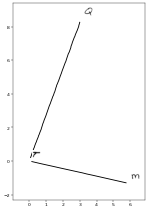

In [17]:
np.random.seed(42)#np.random.randint(100))  # For reproducible results
output_dir = "/home/yfrid/Desktop/stem-whiteboard/dataset/3V/Scalene"

for idx in tqdm(range(10)):
    fig, ax = plt.subplots(figsize=(8,8),dpi = 32)
    ### Randomize Values
    Height = np.random.choice(np.arange(3,10))
    Width = np.random.choice(np.arange(3,10))
    rotation =np.random.choice(np.arange(0,360,5))
    mirror = bool(random.getrandbits(1))
    acute = bool(random.getrandbits(1))
    description = Scalene(Height,Width,rotation = rotation,mirror = mirror,acute=acute)
    create_data(description)

output_dir = "/home/yfrid/Desktop/stem-whiteboard/dataset/3V/Right"
break
for idx in tqdm(range(50)):
    fig, ax = plt.subplots(figsize=(8,8),dpi = 32)
    ### Randomize Values
    Height = np.random.choice(np.arange(3,10))
    Width = np.random.choice(np.arange(3,10))
    rotation =np.random.choice(np.arange(0,360,5))
    mirror = bool(random.getrandbits(1))

    description = Right(Height,Width,rotation = rotation,mirror = mirror)
    create_data(description)
